# Fraud Test data

Data from https://www.kaggle.com/datasets/kartik2112/fraud-detection

In ***Section 1. Load data***, we read features and labels from the original csv file.The whole data is saved to a pickle file for easier(?) access later.

In ***Section 2, Preprocessing: split by feature type***, numerical data is normalized and categorial data converted to either numerical or one-hot encoding. The processed feature and label are saved separately into .pt file for easier access later. If these files exist in your path, you can run ***Section 3. Autoencoder*** without running these first two sections.

In ***Section 3. Autoencoder***, we define a class autoencoder based on the nn.Module class. While data is on cpu, we run train_test_split twice to get the sets train, validation, and test. Then we mask data (mark where data is non-Nan), move them to gpu and train. We find an optimal* set of weights by tracking the reconstructing performance on validation set. These weights are then loaded into the model after training to find the model performance on the test set.

## 1. Load data

In [ ]:
import torch
import pandas as pd
import numpy as np
import math

In [ ]:
#save as pickle so don't need to read from csv every time
data = pd.read_csv('ieee-fraud-detection/train_transaction.csv')
data.to_pickle('ieee_pickled.pkl')

In [ ]:
data = pd.read_pickle('ieee_pickled.pkl')
data.shape # size (590540, 394), second one is label

(590540, 394)

In [ ]:
labels = data.iloc[:, 1]
n_positive = sum(labels)
print(n_positive)
print('percent positive = ', n_positive/len(labels))

20663
percent positive =  0.03499000914417313


In [ ]:
labels = torch.from_numpy(labels.to_numpy()).float()
torch.save(labels, 'labels.pt')

## 2. Preprocessing: split by feature type
Split into numerical and categorial columns.
For categorical, use one hot or 1/0.
For numerical, normalize.

In [ ]:
data_label = data.isFraud
data_features = data.drop(columns=['isFraud'])

# Numerical columns
num_cols = data_features.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Numerical columns:", num_cols)

# Categorical columns
cat_cols = data_features.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical columns:", cat_cols)

Numerical columns: ['TransactionID', 'TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1', 'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', '

### 2.1 Preprocessing: categorical features
Among categorical columns, ProductCD has 5 values, card4 has 4, card6 has 4, ------> one hot <br>
P_emaildomain, R_emaildomain have a lot (59 and 60)<br>
M1-M9 except M4 are True False --------> convert to 1/0 <br>
M4 has values M0, M2, M1 ----------> numerical 0, 2, 1

In [ ]:
#for col in cat_cols:
#    print(data[col].nunique())

In [ ]:
features_expanded = data_features.copy()

In [ ]:
for col in cat_cols:
    if col[0] == 'M':
        if col[1] != 4:
            features_expanded[col] = features_expanded[col].map({'T': 1, 'F': 0})
        else:
            features_expanded[col] = features_expanded[col].map({'M0': 0, 'M1': 1, 'M2':2})
    else:
        features_expanded = pd.get_dummies(features_expanded, columns=[col], dtype=int)

features_expanded.head

<bound method NDFrame.head of         TransactionID  TransactionDT  TransactionAmt  card1  card2  card3  \
0             2987000          86400           68.50  13926    NaN  150.0   
1             2987001          86401           29.00   2755  404.0  150.0   
2             2987002          86469           59.00   4663  490.0  150.0   
3             2987003          86499           50.00  18132  567.0  150.0   
4             2987004          86506           50.00   4497  514.0  150.0   
...               ...            ...             ...    ...    ...    ...   
590535        3577535       15811047           49.00   6550    NaN  150.0   
590536        3577536       15811049           39.50  10444  225.0  150.0   
590537        3577537       15811079           30.95  12037  595.0  150.0   
590538        3577538       15811088          117.00   7826  481.0  150.0   
590539        3577539       15811131          279.95  15066  170.0  150.0   

        card5  addr1  addr2  dist1  ...  R_emaildomain_web.de  \
0       142.0  315.0   87.0   19.0  ...                     0   
1       102.0  325.0   87.0    NaN  ...                     0   
2       166.0  330.0   87.0  287.0  ...                     0   
3       117.0  476.0   87.0    NaN  ...                     0   
4       102.0  420.0   87.0    NaN  ...                     0   
...       ...    ...    ...    ...  ...                   ...   
590535  226.0  272.0   87.0   48.0  ...                     0   
590536  224.0  204.0   87.0    NaN  ...                     0   
590537  224.0  231.0   87.0    NaN  ...                     0   
590538  224.0  387.0   87.0    3.0  ...                     0   
590539  102.0  299.0   87.0    NaN  ...                     0   

        R_emaildomain_windstream.net  R_emaildomain_yahoo.co.jp  \
0                                  0                          0   
1                                  0                          0   
2                                  0                          0   
3                                  0                          0   
4                                  0                          0   
...                              ...                        ...   
590535                             0                          0   
590536                             0                          0   
590537                             0                          0   
590538                             0                          0   
590539                             0                          0   

        R_emaildomain_yahoo.co.uk  R_emaildomain_yahoo.com  \
0                               0                        0   
1                               0                        0   
2                               0                        0   
3                               0                        0   
4                               0                        0   
...                           ...                      ...   
590535                          0                        0   
590536                          0                        0   
590537                          0                        0   
590538                          0                        0   
590539                          0                        0   

        R_emaildomain_yahoo.com.mx  R_emaildomain_yahoo.de  \
0                                0                       0   
1                                0                       0   
2                                0                       0   
3                                0                       0   
4                                0                       0   
...                            ...                     ...   
590535                           0                       0   
590536                           0                       0   
590537                           0                       0   
590538                           0                       0   
590539                          

### 2.2 Preprocessing: scaling numerical features

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
features_normalized=features_expanded.copy()
features_normalized[num_cols] = scaler.fit_transform(features_normalized[num_cols])

In [ ]:
features_normalized.head()

,TransactionID,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,...,R_emaildomain_web.de,R_emaildomain_windstream.net,R_emaildomain_yahoo.co.jp,R_emaildomain_yahoo.co.uk,R_emaildomain_yahoo.com,R_emaildomain_yahoo.com.mx,R_emaildomain_yahoo.de,R_emaildomain_yahoo.es,R_emaildomain_yahoo.fr,R_emaildomain_ymail.com
0,0.000000,0.000000e+00,0.002137,0.743044,NaN,0.381679,0.306569,0.488636,0.836957,0.001847,...,0,0,0,0,0,0,0,0,0,0
1,0.000002,6.359409e-08,0.000900,0.100885,0.608,0.381679,0.014599,0.511364,0.836957,NaN,...,0,0,0,0,0,0,0,0,0,0
2,0.000003,4.387992e-06,0.001840,0.210566,0.780,0.381679,0.481752,0.522727,0.836957,0.027902,...,0,0,0,0,0,0,0,0,0,0
3,0.000005,6.295815e-06,0.001558,0.984824,0.934,0.381679,0.124088,0.854545,0.836957,NaN,...,0,0,0,0,0,0,0,0,0,0
4,0.000007,6.740974e-06,0.001558,0.201023,0.828,0.381679,0.014599,0.727273,0.836957,NaN,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
features_normalized = torch.to_numpy(features_normalized.to_numpy()).float()
torch.save(features_normalized, 'features_normalized.pt')

AttributeError: module 'torch' has no attribute 'to_numpy'

## 3. Autoencoder

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
labels = torch.load('labels.pt')
features_normalized = torch.load('features_normalized.pt')

In [ ]:
#print(labels.shape)
#print(features_normalized.shape)

torch.Size([590540])
torch.Size([590540, 520])


### 3.1 Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
# train test split has to be done while data is still on cpu
X_train, X_test, y_train, y_test = train_test_split(features_normalized, labels, test_size=0.2, random_state=42,
                                                    stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [ ]:
mask_val = ~torch.isnan(X_val).to(device)
X_val_filled = torch.nan_to_num(X_val, nan=0.0)
X_val_filled = X_val_filled.float().to(device) # the model will be on gpu so data should also go on gpu

In [ ]:
mask = ~torch.isnan(X_train).to(device)  # True where data is present
X_filled = torch.nan_to_num(X_train, nan=0.0)  # Replace NaNs with 0
X_filled = X_filled.float().to(device) # convert to all double (twice precision as float).

### 3.2 Autoencoder and training

In [ ]:
class Autoencoder(nn.Module): # here the input nn.Module specifies the super class that Autoencoder is in
    # we are making an object class by modifying an existing class nn.Module
    def __init__(self, input_dim, latent_dim=64):
        super().__init__() # calls initialization of nn.Module object
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(), # this is also a layer but has no weights
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
        )

    def forward(self, x):
        latent = self.encoder(x)
        return self.decoder(latent)

In [ ]:
model = Autoencoder(input_dim=X_filled.shape[1]) # input size has to be number of features
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss(reduction='none')  # We are gonig to calculate error from non-NAN data so reduction is none


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(X_filled, mask)
batch_size = 1024 # You can adjust this batch size based on your GPU memory
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# early-stopping things
min_improvement = 1e-5 # improvements smaller than this (plateau) don't count as imrovement
patience = 5 # do 5 more if not improved
epochs_without_improvement = 0
lowest_epoch_val_loss = float('inf') # track min loss to get best epoch

epochs = 70 # I just picked something large so the loss curves can flatten out
epoch_loss = []
epoch_loss_val = []
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_mask in dataloader:
        optimizer.zero_grad()

        output = model(batch_X)
        loss_matrix = criterion(output, batch_X)  # [batch, features]
        masked_loss = loss_matrix * batch_mask.float()
        loss = masked_loss.sum() / batch_mask.sum()  # average over observed values only

        loss.backward()
        optimizer.step()
        total_loss += loss.item() # get value

    output = model(X_val_filled)
    loss_matrix = criterion(output, X_val_filled)  # [batch, features]
    masked_loss = loss_matrix * mask_val
    loss_val = masked_loss.sum()/mask_val.sum()
    epoch_loss_val.append(loss_val.item())
    epoch_loss.append(total_loss/len(dataloader))
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.4f}, Validation Loss: {loss_val.item():.4f}")
    torch.save(model.state_dict(), f'autoencoder_epoch_{epoch+1}.pth')

    if lowest_epoch_val_loss - loss_val.item() > min_improvement: # improvement in val loss
        lowest_epoch_val_loss = loss_val.item()
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
    if epochs_without_improvement >= patience:
        best_epoch = np.argmin(np.array(epoch_loss_val))
        print(f"Early stopping at epoch {epoch+1}, best epoch {best_epoch + 1}")
        break


Epoch 1, Loss: 0.0063, Validation Loss: 0.0020
Epoch 2, Loss: 0.0014, Validation Loss: 0.0011
Epoch 3, Loss: 0.0009, Validation Loss: 0.0008
Epoch 4, Loss: 0.0007, Validation Loss: 0.0006
Epoch 5, Loss: 0.0006, Validation Loss: 0.0006
Epoch 6, Loss: 0.0005, Validation Loss: 0.0005
Epoch 7, Loss: 0.0005, Validation Loss: 0.0005
Epoch 8, Loss: 0.0005, Validation Loss: 0.0005
Epoch 9, Loss: 0.0004, Validation Loss: 0.0004
Epoch 10, Loss: 0.0004, Validation Loss: 0.0004
Epoch 11, Loss: 0.0004, Validation Loss: 0.0004
Epoch 12, Loss: 0.0003, Validation Loss: 0.0004
Epoch 13, Loss: 0.0003, Validation Loss: 0.0003
Epoch 14, Loss: 0.0003, Validation Loss: 0.0003
Epoch 15, Loss: 0.0003, Validation Loss: 0.0003
Epoch 16, Loss: 0.0003, Validation Loss: 0.0003
Epoch 17, Loss: 0.0003, Validation Loss: 0.0003
Epoch 18, Loss: 0.0003, Validation Loss: 0.0003
Epoch 19, Loss: 0.0003, Validation Loss: 0.0003
Epoch 20, Loss: 0.0003, Validation Loss: 0.0003
Epoch 21, Loss: 0.0002, Validation Loss: 0.0003
E

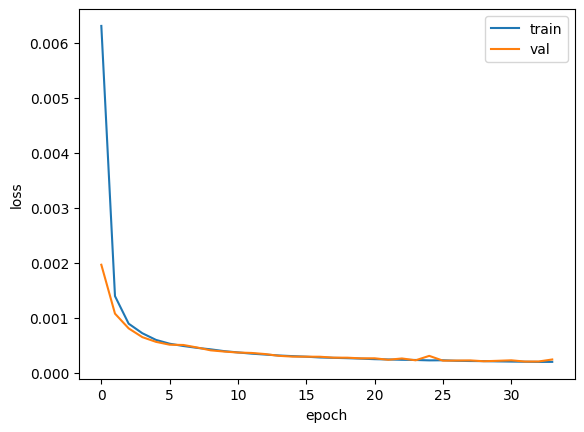

In [ ]:
plt.plot(np.array(epoch_loss))
plt.plot(np.array(epoch_loss_val))
plt.legend(['train', 'val'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### 3.3 Performance on test set

In [ ]:
# here we can just do everything on cpu since we are only a forward pass on the test data
loaded_model = Autoencoder(input_dim=X_filled.shape[1])
loaded_model.load_state_dict(torch.load(f"autoencoder_epoch_{best_epoch + 1}.pth"))
loaded_model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=520, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=520, bias=True)
  )
)

In [ ]:
mask_test = !~torch.isnan(X_test).float()
X_test_filled = torch.nan_to_num(X_test, nan = 0.0).float()
output_test = loaded_model(X_test_filled)
error = criterion(output_test, X_test_filled)
point_error = torch.mean(error, dim=1)

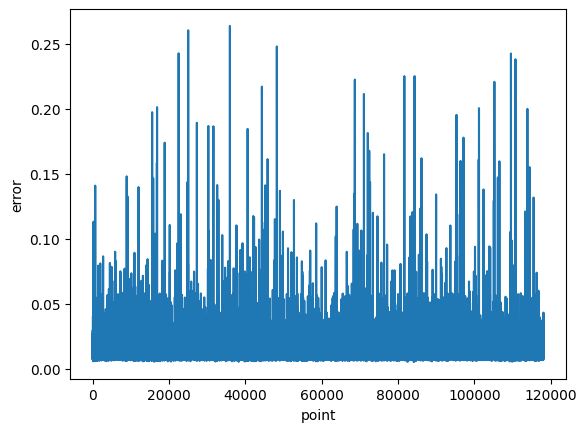

In [ ]:
plt.plot(point_error.detach().numpy())
plt.xlabel('point')
plt.ylabel('error')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

# [[True Negatives (TN), False Positives (FP)]
#  [False Negatives (FN), True Positives (TP)]]

In [ ]:
for threshold in np.arange(0.05, 0.2, 0.01):
    pred_fraud = torch.where(point_error > threshold, 1, 0) # if > threshold, mark as 1, else mark as 0
    print(f"threshold: {threshold:.2f}")
    print(confusion_matrix(y_test.numpy(), pred_fraud.numpy()))
    print(f"f1: {f1_score(y_test.numpy(), pred_fraud.numpy())}")


threshold: 0.05
[[113552    423]
 [  4108     25]]
f1: 0.010914647456887142
threshold: 0.06
[[113762    213]
 [  4121     12]]
f1: 0.005507113354749885
threshold: 0.07
[[113800    175]
 [  4123     10]]
f1: 0.004631773969430292
threshold: 0.08
[[113845    130]
 [  4127      6]]
f1: 0.0028109627547434997
threshold: 0.09
[[113876     99]
 [  4128      5]]
f1: 0.002360160490913382
threshold: 0.10
[[113892     83]
 [  4130      3]]
f1: 0.001422137947380896
threshold: 0.11
[[113904     71]
 [  4130      3]]
f1: 0.0014261944378416924
threshold: 0.12
[[113919     56]
 [  4131      2]]
f1: 0.000954426151276545
threshold: 0.13
[[113927     48]
 [  4132      1]]
f1: 0.00047824007651841227
threshold: 0.14
[[113934     41]
 [  4132      1]]
f1: 0.00047904191616766467
threshold: 0.15
[[113943     32]
 [  4132      1]]
f1: 0.00048007681228996637
threshold: 0.16
[[113947     28]
 [  4132      1]]
f1: 0.0004805382027871216
threshold: 0.17
[[113951     24]
 [  4133      0]]
f1: 0.0
threshold: 0.18
[[11